In [1]:
# SPDX-FileCopyrightText: 2022 Aleksander Grochowicz
#
# SPDX-License-Identifier: GPL-3.0-or-later

from matplotlib.ticker import AutoMinorLocator
import pandas as pd
from datetime import date
import holidays
from utilities import compute_cdd_hdd_artificial, create_daily_data, create_hourly_data

# Load temperature data

In [2]:
temperatures = pd.read_csv('original_data/europe_temperatures_1980-2020.csv', index_col = [0], infer_datetime_format=True)
temperatures.drop('IS', axis = 1) # Remove Iceland
temperatures.index = pd.to_datetime(temperatures.index)

C:\Users\JD278300\AppData\Local\Temp\ipykernel_6548\252671962.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temperatures = pd.read_csv('original_data/europe_temperatures_1980-2020.csv', index_col = [0], infer_datetime_format=True)


# Load regression parameters


In [3]:
reg_parameters_days = pd.read_csv('processing/reg_parameters_days_of_week_2010-2014.csv', index_col = [0])
reg_parameters_hours = pd.read_csv('processing/reg_parameters_hours_of_week_2010-2014.csv', index_col = [0])
reg_parameters_temp = pd.read_csv('processing/reg_parameters_temp_2010-2014.csv', index_col = [0])
reg_parameters_trend = pd.read_csv('processing/reg_parameters_trend_2010-2014.csv', index_col = [0])

Since our validation year is 2015, compared to the training data from 2010 to 2014, all weather years that we use will be processed on the premise that they happened in 2015.

In [4]:
years = list(temperatures.index.to_series().dt.year.unique())
countries = list(temperatures.columns)

Add holidays as previously with the `holidays` package and by adding Christmas week and for some countries Orthodox Christmas. 

In [6]:
list_holidays = {}
yrs = years.copy()
for c in countries:
    if c == 'EL':
        list_holidays[c] = holidays.CountryHoliday('GR', years = yrs)
    else:
        try:
            list_holidays[c] = holidays.CountryHoliday(c, years = yrs)
        except KeyError:
            list_holidays[c] = holidays.HolidayBase() #if no holidays are available, e.g. ME, MK        

julian = ['ME', 'MK', 'RS']
gregorian = countries.copy()
for i in countries:
    if i in julian:
        gregorian.remove(i)

# Add last week of the year as holidays.
for y in list(yrs):
    for i in gregorian:
        list_holidays[i].append(date(y,1,2))
        list_holidays[i].append(list(pd.date_range(start = date(y, 12, 24), end = date(y, 12, 31), freq = '1D')))
    for i in julian:
        list_holidays[i].append(list(pd.date_range(start = date(y, 1, 6), end = date(y, 1, 8), freq = '1D')))
        

In [7]:
#Add German holidays before reunification (so include reunification as everything is assumed to be in 2015)
overlapping_holidays = ['Neujahrestag', 'Karfreitag', 'Ostermontag', 'Auffahrt', 'Pfingstmontag', 'Weihnachten']
for y in range(1980, 1991):
    for date, name in sorted(holidays.CH(years = y).items()):
        if name in overlapping_holidays:
            list_holidays['DE'].append({date: name})
    list_holidays['DE'].append(str(y)+'-05-01')
    list_holidays['DE'].append(str(y)+'-10-03')
    list_holidays['DE'].append(str(y)+'-12-26')

In [8]:
#Add Slovenian holidays before 1992
AT_SI = ['Neujahr', 'Allerheiligen', 'Stefanitag'] #New Year's, All Saints Day, Independence Day on Boxing Day
for y in range(1980, 1992):
    for date, name in sorted(holidays.AT(years = y).items()):
        if name in AT_SI:
            list_holidays['SI'].append({date: name})
    list_holidays['SI'].append(str(y)+'-02-08') #Preseren Day
    list_holidays['SI'].append(str(y)+'-04-27') #Day of uprising against occupation
    list_holidays['SI'].append(str(y)+'-05-01') #May 1
    list_holidays['SI'].append(str(y)+'-05-02') #May 1 over two days
    list_holidays['SI'].append(str(y)+'-06-25') #Statehood Day

In [9]:
#Add Bulgarian holidays before 1990
RO_BG = ['Paștele', 'Anul Nou', 'Ziua Muncii', 'Crăciunul'] #Orthodox Easter, New Year, First of May, Christmas
for y in range(1980, 1990):
    for date, name in sorted(holidays.RO(years = y).items()):
        if name in RO_BG:
            list_holidays['BG'].append({date: name})
    list_holidays['BG'].append(str(y)+'-03-03') #Liberation Day
    list_holidays['BG'].append(str(y)+'-05-06') #Saint George's Day
    list_holidays['BG'].append(str(y)+'-05-24') #Bulgarian Education and Culture and Slavonic Literature Day
    list_holidays['BG'].append(str(y)+'-09-06') #Unification Day
    list_holidays['BG'].append(str(y)+'-09-22') #independence Day

Compute HDD and CDD for all years (with the threshold at 15.5 degrees Celsius).

In [10]:
temperatures_daily = temperatures.resample('1D').mean()
temperatures_daily['weekday'] = temperatures_daily.index.to_series().dt.dayofweek
temperatures_daily['holiday'] = False
temp_daily = {}
for i in countries:
    temp_daily[i] = pd.DataFrame(temperatures_daily[[i, 'weekday', 'holiday']])
    temp_daily[i].columns = ['temp', 'weekday', 'holiday']
temp_with_holidays = temp_daily.copy()
for i in temp_with_holidays.keys():
    for j in temp_with_holidays[i].index:
        if j in list_holidays[i]:
            temp_with_holidays[i].at[j, 'holiday'] = True

In [11]:
daily_hc = compute_cdd_hdd_artificial(temp_daily, countries, threshold_hdd = 15.5, threshold_cdd = 15.5)

Create the artificial demand

In [12]:
countries = reg_parameters_trend.columns

In [13]:
artificial_demand_daily, days, first_day = create_daily_data(reg_parameters_days, reg_parameters_trend.loc["par_trend"], daily_hc, reg_parameters_temp.T, countries, start = 1980, end= 2021, validation_days=1826)

In [14]:
artificial_demand_hourly = create_hourly_data(artificial_demand_daily, reg_parameters_hours, temperatures, first_day, countries, start = 1980, end = 2021)

c:\Users\JD278300\Documents\Stage\Create data\multidecade-data\load data\utilities.py:459: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  0 + artificial[i][j // 24] * weekly_profile[i].iloc[k]


In [15]:
artificial_demand_ts = pd.concat(artificial_demand_hourly, axis = 1).round(1)

In [16]:
artificial_demand_ts.to_csv('europe_demand_artificial_1980-2020.csv')

<Axes: xlabel='time'>

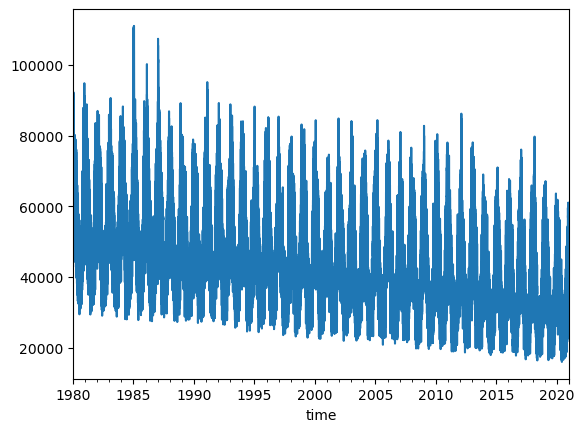

In [18]:
artificial_demand_ts['FR'].plot()